### RIR Watermark Experiment
- Test the quality of clean speech and rir
- Test the synthesized re-echoed speech
- Test decoding accuracy :BER

In [14]:
import sys, torch, torchaudio
from model import *
from new_dataloader import get_dataloader, MyLibriSpeech, RIRS_Dataset

audio_dataset_val = MyLibriSpeech(url="dev-clean",sr=16000, duration=2)
rir_dataset_val = RIRS_Dataset(sr=16000, duration=2)

audio_dl_val, rir_dl_val = get_dataloader(audio_dataset_val, rir_dataset_val, batch_size=4, num_workers=16)

audio, rir = next(iter(zip(audio_dl_val, rir_dl_val)))

rs = torchaudio.functional.fftconvolve(audio, rir, mode='full')

In [15]:
device = "cpu"

separator = ReEcho_Separator()
generator = ReEcho_Generator()
watermarker = ReEcho_WM(msg_len=5)
spec_transform = SpectrogramTransform()

model = torch.load("checkpoints/0715_0327/rir_model_epoch_50.pth")

# Load model parameters
separator.load_state_dict(model['separator_state_dict'])
generator.load_state_dict(model['generator_state_dict'])
watermarker.load_state_dict(model['watermarker_state_dict'])

separator.eval()
generator.eval()
watermarker.eval()

ReEcho_WM(
  (wm_net): WMEmbedderExtractor(
    (msg_codebook): Embedding(32, 128)
    (embedder): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): Swish(
        (silu): SiLU()
      )
      (2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (encoder): ConformerEncoder(
      (input_proj): Sequential(
        (0): Linear(in_features=513, out_features=256, bias=True)
        (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (2): Swish(
          (silu): SiLU()
        )
      )
      (encoder): ConformerEncoder(
        (layers): ModuleList(
          (0-11): 12 x ConformerEncoderLayer(
            (mha_layer): RelPosMHAXL(
              (dropout_att): Dropout(p=0.1, inplace=False)
              (out_proj): Linear(in_features=256, out_features=256, bias=True)
              (linear_pos): Linear(in_features=256, out_features=256, bias=False)
            )
            (convolution_module): ConvolutionModule(
        

In [16]:
import torchaudio.functional as F

with torch.no_grad():
    msg = torch.randint(0, 2, (rs.shape[0], watermarker.msg_len), device=device)

    # feature extraction
    spec_masked, rir_emb = separator(rs)

    # watermark embedding 
    rir_emb_wm = watermarker.embedding(msg, rir_emb)

    # generation
    rir_est = generator(rir_emb_wm)

    idx = torch.randperm(audio.shape[0])
    audio_permute = audio[idx]
    rs_synthesize = F.fftconvolve(audio_permute, rir_est, mode='full')
    rs_synthesize = rs_synthesize[:, :rs.shape[1]]


    # watermark extraction
    rs_resyn_spec = spec_transform(rs_synthesize)
    msg_decoded = watermarker.extraction(rs_resyn_spec, mode='msg')

    print(msg_decoded)
    print(msg)
    print(msg_decoded == msg)

ic| spec.shape: torch.Size([4, 513, 250]), 'B, F, T'


ic| out.shape: torch.Size([4, 250, 256]), 'B, T, d_model'
ic| x_in.shape: torch.Size([4, 256, 250])
ic| spec_masked.shape: torch.Size([4, 513, 250]), 'B, F, T'
ic| out.shape: torch.Size([4, 1, 25600])
ic| amplitude.shape: torch.Size([4, 10, 20])
    envelope.shape: torch.Size([4, 20, 24320])
    t_end: 1.52
ic| late_reverb_freq.shape: torch.Size([4, 10, 24320])
ic| filtered_noise.shape: torch.Size([4, 10, 24320])


tensor([[0., 0., 0., 0., 1.],
        [0., 1., 1., 1., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.]])
tensor([[0, 0, 0, 0, 1],
        [0, 1, 1, 1, 0],
        [1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1]])
tensor([[True, True, True, True, True],
        [True, True, True, True, True],
        [True, True, True, True, True],
        [True, True, True, True, True]])


Now, show the results of task 1:

In [17]:
from IPython.display import Audio, display
from speechbrain.inference.vocoders import HIFIGAN
hifi_gan = HIFIGAN.from_hparams(source="speechbrain/tts-hifigan-libritts-16kHz", savedir="pretrained_models/tts-hifigan-libritts-16kHz")

mel_transform = MelScaleTransform()
dereverb = hifi_gan.decode_batch(mel_transform(spec_masked))
re_synthesized = F.fftconvolve(dereverb, rir_est, mode='full')

print("clean")
display(Audio(audio[0].numpy(), rate=16000))
print("rs")
display(Audio(rs[0].numpy(), rate=16000))
print("dereverb")
display(Audio(dereverb[0].numpy(), rate=16000))
print("re_synthesized")
display(Audio(re_synthesized[0].numpy(), rate=16000))

clean


rs


dereverb


re_synthesized


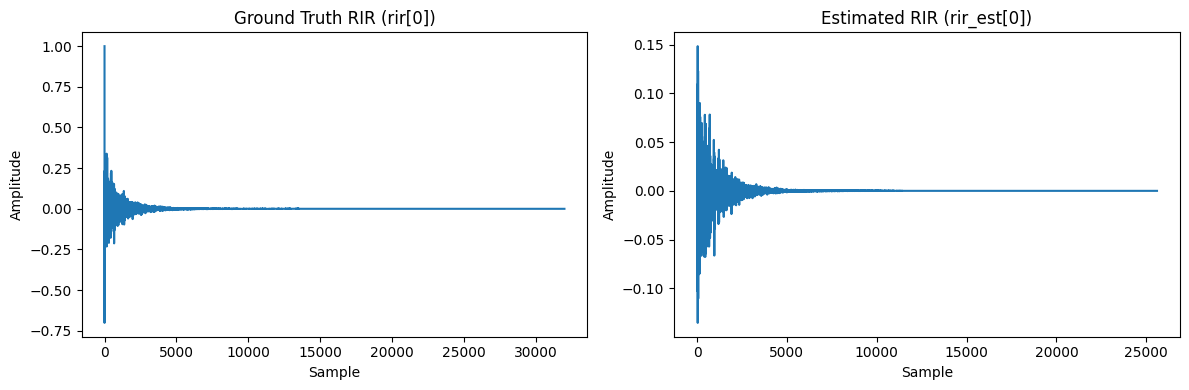

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(rir[0].squeeze().cpu().numpy())
plt.title("Ground Truth RIR (rir[0])")
plt.xlabel("Sample")
plt.ylabel("Amplitude")

plt.subplot(1, 2, 2)
plt.plot(rir_est[0].detach().squeeze().cpu().numpy())
plt.title("Estimated RIR (rir_est[0])")
plt.xlabel("Sample")
plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()



TypeError: Invalid shape (1, 257, 251) for image data

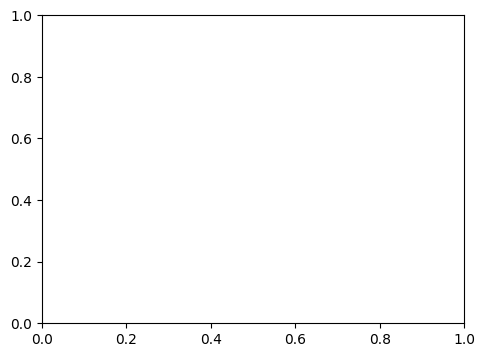

In [20]:
import torchaudio

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
spec_rir = torchaudio.transforms.Spectrogram(n_fft=512, hop_length=128)(rir[0].cpu())
plt.imshow(10 * np.log10(spec_rir.numpy() + 1e-8), aspect='auto', origin='lower')
plt.title("Spectrogram of Ground Truth RIR")
plt.xlabel("Frame")
plt.ylabel("Frequency Bin")
plt.colorbar(label="dB")

plt.subplot(1, 2, 2)
spec_rir_est = torchaudio.transforms.Spectrogram(n_fft=512, hop_length=128)(rir_est[0].detach().cpu())
plt.imshow(10 * np.log10(spec_rir_est.numpy() + 1e-8), aspect='auto', origin='lower')
plt.title("Spectrogram of Estimated RIR")
plt.xlabel("Frame")
plt.ylabel("Frequency Bin")
plt.colorbar(label="dB")

plt.tight_layout()
plt.show()
